# Librerias y datos

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import scipy.stats as st
from sklearn.model_selection import learning_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report,make_scorer
from scipy.stats import loguniform
from sklearn.tree import DecisionTreeClassifier

In [ ]:
df = sns.load_dataset("titanic")
df.shape
df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Creación y revisión de caracteristicas (EDA conclusiones)

In [ ]:
candidate = []

for c in ['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked','class', 'who', 'adult_male', 'alone']:
    if c in df.columns:
        candidate.append(c)
df_class =  df[candidate + ['survived']].copy()
df =  df[candidate + ['fare']].copy()
print(f"Columnas usadas: {candidate + ['fare']}")
df.sample(5)

Columnas usadas: ['pclass', 'sex', 'age', 'sibsp', 'parch', 'embarked', 'class', 'who', 'adult_male', 'alone', 'fare']


,pclass,sex,age,sibsp,parch,embarked,class,who,adult_male,alone,fare
774,2,female,54.0,1,3,S,Second,woman,False,False,23.00
767,3,female,30.5,0,0,Q,Third,woman,False,True,7.75
799,3,female,30.0,1,1,S,Third,woman,False,False,24.15
363,3,male,35.0,0,0,S,Third,man,True,True,7.05
884,3,male,25.0,0,0,S,Third,man,True,True,7.05


In [ ]:
# FamilySize: tamaño de la familia (incluye a la persona)
if all(c in df_class.columns for c in ['sibsp','parch']):
    df_class['familysize'] = df_class['sibsp'].fillna(0) + df_class['parch'].fillna(0) + 1

# Age bins: discretización de edad (puede capturar efectos no lineales)
if 'age' in df_class.columns:
    bins = [-np.inf, 12, 18, 35, 55, np.inf]
    labels = ['child','teen','young_adult','adult','senior']
    df_class['age_group'] = pd.cut(df_class['age'], bins=bins, labels=labels)

# Interacción 'pclass x sex' (socioeconómico + género)
if all(c in df_class.columns for c in ['pclass','sex']):
    df_class['pclass_sex'] = df_class['pclass'].astype(str) + "_" + df_class['sex'].astype(str)

# Vista rápida
df_class.head()

,pclass,sex,age,sibsp,parch,embarked,class,who,adult_male,alone,survived,familysize,age_group,pclass_sex
0,3,male,22.0,1,0,S,Third,man,True,False,0,2,young_adult,3_male
1,1,female,38.0,1,0,C,First,woman,False,False,1,2,adult,1_female
2,3,female,26.0,0,0,S,Third,woman,False,True,1,1,young_adult,3_female
3,1,female,35.0,1,0,S,First,woman,False,False,1,2,young_adult,1_female
4,3,male,35.0,0,0,S,Third,man,True,True,0,1,young_adult,3_male


In [ ]:
# FamilySize: tamaño de la familia (incluye a la persona)
if all(c in df.columns for c in ['sibsp','parch']):
    df['familysize'] = df['sibsp'].fillna(0) + df['parch'].fillna(0) + 1

# Age bins: discretización de edad (puede capturar efectos no lineales)
if 'age' in df.columns:
    bins = [-np.inf, 12, 18, 35, 55, np.inf]
    labels = ['child','teen','young_adult','adult','senior']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# Interacción 'pclass x sex' (socioeconómico + género)
if all(c in df.columns for c in ['pclass','sex']):
    df['pclass_sex'] = df['pclass'].astype(str) + "_" + df['sex'].astype(str)

# Vista rápida
df.head()

,pclass,sex,age,sibsp,parch,embarked,class,who,adult_male,alone,fare,familysize,age_group,pclass_sex
0,3,male,22.0,1,0,S,Third,man,True,False,7.2500,2,young_adult,3_male
1,1,female,38.0,1,0,C,First,woman,False,False,71.2833,2,adult,1_female
2,3,female,26.0,0,0,S,Third,woman,False,True,7.9250,1,young_adult,3_female
3,1,female,35.0,1,0,S,First,woman,False,False,53.1000,2,young_adult,1_female
4,3,male,35.0,0,0,S,Third,man,True,True,8.0500,1,young_adult,3_male


# Regresion

# Regresion Lineal

In [ ]:
target = 'fare'
num_features = [c for c in ['age','sibsp','parch','familysize'] if c in df.columns]
cat_features = [c for c in ['sex','embarked','embark_town','pclass','class','who','adult_male','alone','age_group','pclass_sex'] if c in df.columns]


X = df[num_features + cat_features].copy()
y = df[target].copy()

In [ ]:
print("Numéricas:", num_features)
print("Categóricas:", cat_features)
print("Dimensiones X/y:", X.shape, y.shape)

Numéricas: ['age', 'sibsp', 'parch', 'familysize']
Categóricas: ['sex', 'embarked', 'pclass', 'class', 'who', 'adult_male', 'alone', 'age_group', 'pclass_sex']
Dimensiones X/y: (891, 13) (891,)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 13), (179, 13), (712,), (179,))

### Pipelines

In [ ]:
numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [ ]:
categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])


In [ ]:
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])


## Transformacion de X y Y

In [ ]:
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

In [ ]:
# Sanity checks de tamaños y alineaciones
print("X_train_prep:", X_train_prep.shape)
print("y_train:", y_train.shape)
print("X_test_prep:", X_test_prep.shape)
print("y_test:", y_test.shape)

assert len(X_train_prep) == len(y_train), "Desalineación: X_train_prep y y_train"
assert len(X_test_prep)  == len(y_test),  "Desalineación: X_test_prep y y_test"

X_train_prep: (712, 33)
y_train: (712,)
X_test_prep: (179, 33)
y_test: (179,)


### Modelo simple de regresion Lineal

In [ ]:
ols = LinearRegression()

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    ols,
    X_train_prep, y_train,
    cv=3,
    scoring="r2",
    train_sizes=np.linspace(0.2, 1.0, 5),  # tamaños de entrenamiento
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

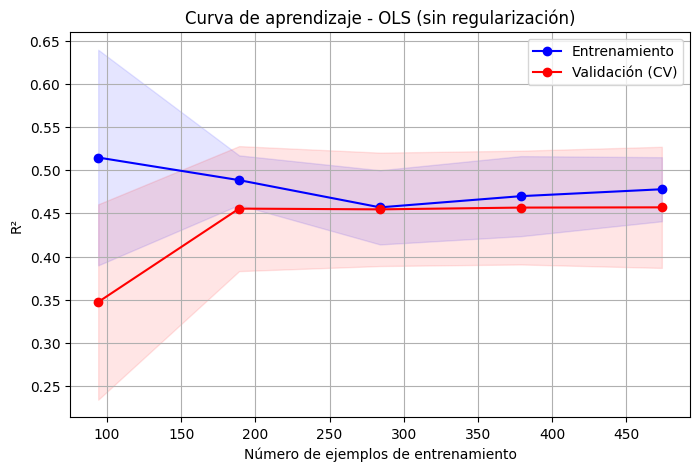

In [ ]:
# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Entrenamiento')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='Validación (CV)')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - OLS (sin regularización)")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

## Regularización

In [ ]:
# --------------------------------------------------
# Validación cruzada
# --------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)
metrics = {}

# --------------------------------------------------
# Función para entrenar y evaluar modelos
# --------------------------------------------------
def eval_and_store(name, model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    r2 = r2_score(yte, pred)
    rmse = np.sqrt(mean_squared_error(yte, pred))
    mae = mean_absolute_error(yte, pred)

    metrics[name] = {"R2": r2, "RMSE": rmse, "MAE": mae}
    print(f"{name} - R2: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

    return model, pred

# --------------------------------------------------
# Modelos
# --------------------------------------------------
# OLS
ols = LinearRegression()
ols_model, ols_pred = eval_and_store("OLS", ols, X_train_prep, y_train, X_test_prep, y_test)

# Ridge Regression Ridge disminuye los coeficientes de mis variables un poco pero no las elimina
ridge = RidgeCV(alphas=np.logspace(-3, 3, 13), cv=cv)
ridge_model, ridge_pred = eval_and_store("Ridge", ridge, X_train_prep, y_train, X_test_prep, y_test)

# Lasso Regression Lasso disminuye los coeficientes de mis variables un poco y algunas llegan a 0 y las elimnina
lasso = LassoCV(alphas=np.logspace(-3, 3, 13), cv=cv, max_iter=5000)
lasso_model, lasso_pred = eval_and_store("Lasso", lasso, X_train_prep, y_train, X_test_prep, y_test)

# ElasticNet Regression L1 + L2
elasticnet = ElasticNetCV(alphas=np.logspace(-3, 3, 13), l1_ratio=0.5, cv=cv, max_iter=5000, random_state=42)
elasticnet_model, elasticnet_pred = eval_and_store("ElasticNet", elasticnet, X_train_prep, y_train, X_test_prep, y_test)

OLS - R2: 0.4052, RMSE: 30.3387, MAE: 18.1627
Ridge - R2: 0.4482, RMSE: 29.2206, MAE: 16.9906
Lasso - R2: 0.4307, RMSE: 29.6816, MAE: 17.2207
ElasticNet - R2: 0.4544, RMSE: 29.0552, MAE: 16.7735


### Validacion cruzada

In [ ]:
# --------------------------------------------------
# 1️⃣ Función para calcular RMSE
# --------------------------------------------------
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# --------------------------------------------------
# 2️⃣ Función para evaluar un modelo con CV paso a paso
# --------------------------------------------------

#Y un flag scale que si está en True mete un StandardScaler dentro de cada fold (así se evita data leakage).
def evaluate_model_with_cv(model, X, y, cv, name="Modelo", scale=True):
    """
    Evalúa un modelo con validación cruzada.
    scale=True aplica StandardScaler dentro de cada fold (evita data leakage)
    """
    r2_scores, rmse_scores, mae_scores = [], [], []

    fold = 1
    for train_idx, val_idx in cv.split(X):
        #cv.split(X) genera los índices de train y test en cada fold.

        #cEn cada iteración:

        #train_idx: qué filas van a entrenamiento.

        #val_idx: qué filas van a validación.
        # Split de datos
        X_train_fold = X.iloc[train_idx] if hasattr(X, "iloc") else X[train_idx]
        y_train_fold = y.iloc[train_idx] if hasattr(y, "iloc") else y[train_idx]
        X_val_fold = X.iloc[val_idx] if hasattr(X, "iloc") else X[val_idx]
        y_val_fold = y.iloc[val_idx] if hasattr(y, "iloc") else y[val_idx]

        # Crear pipeline con escalado si se requiere
        if scale:
            fold_model = Pipeline([
                ('scaler', StandardScaler()),
                ('regressor', model)
            ])
        else:
            fold_model = model

        # Entrenar y predecir
        fold_model.fit(X_train_fold, y_train_fold)
        y_pred = fold_model.predict(X_val_fold)

        # Calcular métricas
        r2_scores.append(r2_score(y_val_fold, y_pred))
        rmse_scores.append(calculate_rmse(y_val_fold, y_pred))
        mae_scores.append(mean_absolute_error(y_val_fold, y_pred))

        print(f"{name} - Fold {fold}: R2={r2_scores[-1]:.4f}, RMSE={rmse_scores[-1]:.4f}, MAE={mae_scores[-1]:.4f}")
        fold += 1

    # Promedio y desviación estándar
    results = {
        "Modelo": name,
        "R2_mean": np.mean(r2_scores),
        "R2_std": np.std(r2_scores),
        "RMSE_mean": np.mean(rmse_scores),
        "RMSE_std": np.std(rmse_scores),
        "MAE_mean": np.mean(mae_scores),
        "MAE_std": np.std(mae_scores),
        "R2_scores": r2_scores,
        "RMSE_scores": rmse_scores,
        "MAE_scores": mae_scores
    }

    print(f"\n{name} - CV promedio: R2={results['R2_mean']:.4f}±{results['R2_std']:.4f}, "
          f"RMSE={results['RMSE_mean']:.4f}±{results['RMSE_std']:.4f}, "
          f"MAE={results['MAE_mean']:.4f}±{results['MAE_std']:.4f}\n")

    return results

# --------------------------------------------------
# 3️⃣ Configuración de CV y modelos
# --------------------------------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

modelos = [
    ("OLS", LinearRegression()),
    ("RidgeCV", RidgeCV(alphas=np.logspace(-3,3,25), cv=cv)),
    ("LassoCV", LassoCV(cv=cv, random_state=42, max_iter=5000)),
    ("ElasticNetCV", ElasticNetCV(alphas=np.logspace(-3,3,25), l1_ratio=0.5, cv=cv, max_iter=5000, random_state=42))
]

# --------------------------------------------------
# 4️⃣ Evaluación de todos los modelos
# --------------------------------------------------
cv_results = []
for name, model in modelos:
    res = evaluate_model_with_cv(model, X_train_prep, y_train, cv, name=name, scale=True)
    cv_results.append(res)

# Convertimos a DataFrame para comparación
df_cv = pd.DataFrame(cv_results).set_index("Modelo")
df_cv = df_cv[["R2_mean","R2_std","RMSE_mean","RMSE_std","MAE_mean","MAE_std"]].sort_values("R2_mean", ascending=False)
df_cv


OLS - Fold 1: R2=0.4239, RMSE=40.8516, MAE=16.8351
OLS - Fold 2: R2=0.5333, RMSE=27.5111, MAE=16.5569
OLS - Fold 3: R2=0.2814, RMSE=62.9653, MAE=24.6566
OLS - Fold 4: R2=0.5899, RMSE=23.6887, MAE=13.5150
OLS - Fold 5: R2=0.5271, RMSE=30.0619, MAE=16.7587

OLS - CV promedio: R2=0.4711±0.1089, RMSE=37.0157±14.1732, MAE=17.6645±3.7106

RidgeCV - Fold 1: R2=0.4233, RMSE=40.8720, MAE=15.1156
RidgeCV - Fold 2: R2=0.5430, RMSE=27.2226, MAE=15.3670
RidgeCV - Fold 3: R2=0.2868, RMSE=62.7288, MAE=23.9355
RidgeCV - Fold 4: R2=0.5992, RMSE=23.4178, MAE=12.1825
RidgeCV - Fold 5: R2=0.5358, RMSE=29.7827, MAE=15.0546

RidgeCV - CV promedio: R2=0.4776±0.1112, RMSE=36.8048±14.2052, MAE=16.3310±3.9768

LassoCV - Fold 1: R2=0.4324, RMSE=40.5482, MAE=15.8392
LassoCV - Fold 2: R2=0.5395, RMSE=27.3252, MAE=15.7252
LassoCV - Fold 3: R2=0.2829, RMSE=62.8998, MAE=24.1124
LassoCV - Fold 4: R2=0.5997, RMSE=23.4032, MAE=12.4985
LassoCV - Fold 5: R2=0.5363, RMSE=29.7681, MAE=15.6818

LassoCV - CV promedio: R2=0.47

,R2_mean,R2_std,RMSE_mean,RMSE_std,MAE_mean,MAE_std
Modelo,,,,,,
ElasticNetCV,0.479285,0.110632,36.746207,14.190213,16.511169,3.833726
LassoCV,0.478168,0.111484,36.788886,14.240370,16.771406,3.880672
RidgeCV,0.477626,0.111188,36.804775,14.205199,16.331041,3.976787
OLS,0.471101,0.108925,37.015736,14.173193,17.664459,3.710613


[1.00000000e-03 1.77827941e-03 3.16227766e-03 5.62341325e-03
 1.00000000e-02 1.77827941e-02 3.16227766e-02 5.62341325e-02
 1.00000000e-01 1.77827941e-01 3.16227766e-01 5.62341325e-01
 1.00000000e+00 1.77827941e+00 3.16227766e+00 5.62341325e+00
 1.00000000e+01 1.77827941e+01 3.16227766e+01 5.62341325e+01
 1.00000000e+02 1.77827941e+02 3.16227766e+02 5.62341325e+02
 1.00000000e+03]


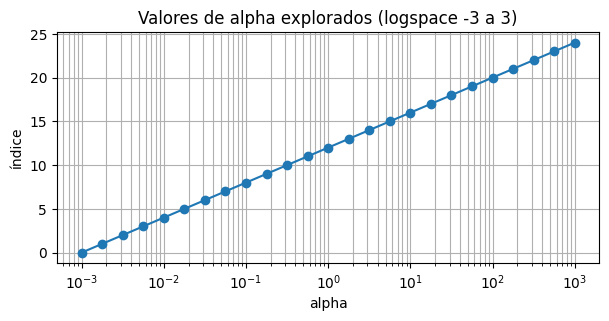

In [ ]:
alphas = np.logspace(-3, 3, 25)
print(alphas)

plt.figure(figsize=(7,3))
plt.semilogx(alphas, range(len(alphas)), marker="o")
plt.xlabel("alpha")
plt.ylabel("índice")
plt.title("Valores de alpha explorados (logspace -3 a 3)")
plt.grid(True, which="both")
plt.show()

In [ ]:
# Escoger el mejor según R² medio
best_model_name = df_cv["R2_mean"].idxmax()
print(f"👉 Mejor modelo según CV: {best_model_name}")

# Entrenar con todo el train set
best_model = [m for n,m in modelos if n==best_model_name][0]
best_model.fit(X_train_prep, y_train)

# Evaluar en test
y_pred = best_model.predict(X_test_prep)
print("R2 test:", r2_score(y_test, y_pred))
print("RMSE test:", np.sqrt(mean_squared_error(y_test, y_pred)))

👉 Mejor modelo según CV: ElasticNetCV
R2 test: 0.45444775808768256
RMSE test: 29.055183669738437


👉 Resultados en Test
R2 test  = 0.4382
RMSE test = 29.4854


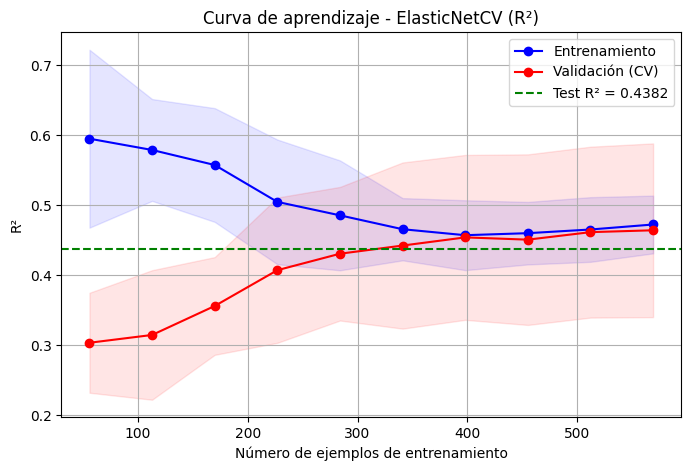

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    ElasticNetCV(alphas=np.logspace(-3, 3, 25), cv=5, random_state=42, max_iter=5000),
    X_train_prep, y_train,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

# Promedio y desviación
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# ===================================================
# Entrenar mejor modelo en todo el train y evaluar en test
# ===================================================
best_model = ElasticNetCV(alphas=np.logspace(-3, 3, 25), cv=5, random_state=42, max_iter=5000)
best_model.fit(X_train_prep, y_train)

y_pred = best_model.predict(X_test_prep)
r2_test = r2_score(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

print("👉 Resultados en Test")
print(f"R2 test  = {r2_test:.4f}")
print(f"RMSE test = {rmse_test:.4f}")

# ===================================================
# Graficar curva de aprendizaje con R² de test
# ===================================================
plt.figure(figsize=(8,5))
plt.title("Curva de aprendizaje - ElasticNetCV (R²)")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Entrenamiento")
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue")
plt.plot(train_sizes, val_scores_mean, 'o-', color="red", label="Validación (CV)")
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color="red")

# Línea horizontal con el R² de test
plt.axhline(y=r2_test, color="green", linestyle="--", label=f"Test R² = {r2_test:.4f}")

plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend(loc="best")
plt.grid(True)
plt.show()


## Arboles de decision

In [ ]:
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

print("Shapes post-prepro:", X_train_prep.shape, X_test_prep.shape)


Shapes post-prepro: (712, 33) (179, 33)


In [ ]:
# Target = fare (regresión)
y = df["fare"]

# Features (quitamos columnas que no sirven para predicción directa)
X = df.drop(columns=["fare"])

# Dummies para variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X.shape, X_train.shape, X_test.shape

((891, 23), (712, 23), (179, 23))

In [ ]:
tree_base = DecisionTreeRegressor(random_state=42)
tree_base.fit(X_train, y_train)

y_pred = tree_base.predict(X_test)

print("R2 test:", r2_score(y_test, y_pred))
print("RMSE test:", mean_squared_error(y_test, y_pred))

R2 test: -0.8061096120896116
RMSE test: 2794.8275096869256


In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    tree_base,
    X_train, y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),  # fracciones del dataset
    shuffle=True,
    random_state=42,
    n_jobs=-1
)


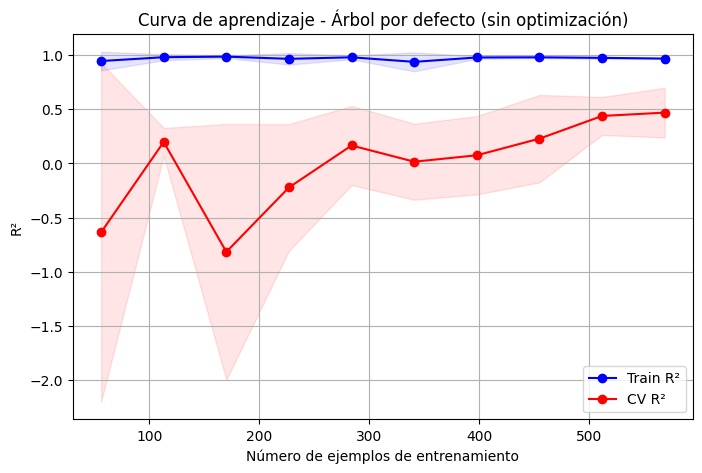

In [ ]:
# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV R²')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Árbol por defecto (sin optimización)")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

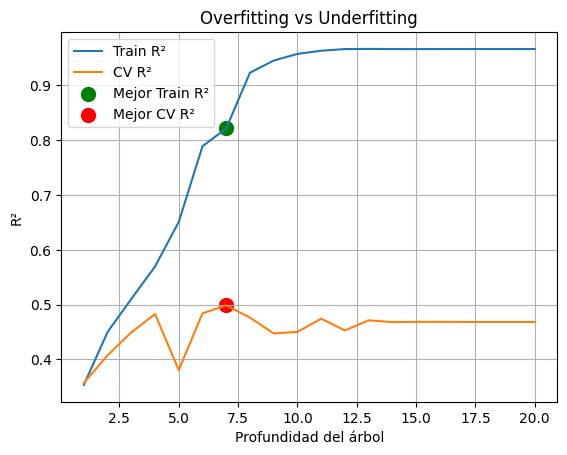

Mejor profundidad: 7
Train R² en mejor escenario: 0.8214928209111874
CV R² en mejor escenario: 0.49856521526800635


In [ ]:
train_scores, cv_scores = [], []

for d in range(1, 21):
    tree = DecisionTreeRegressor(max_depth=d, random_state=42)
    tree.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, tree.predict(X_train)))
    cv_scores.append(cross_val_score(tree, X_train, y_train, cv=5, scoring="r2").mean())

# Mejor CV R²
best_idx = cv_scores.index(max(cv_scores))

plt.plot(range(1, 21), train_scores, label="Train R²")
plt.plot(range(1, 21), cv_scores, label="CV R²")

# Marcar el mejor escenario
plt.scatter(best_idx+1, train_scores[best_idx], color='green', s=100, label="Mejor Train R²")
plt.scatter(best_idx+1, cv_scores[best_idx], color='red', s=100, label="Mejor CV R²")

plt.xlabel("Profundidad del árbol")
plt.ylabel("R²")
plt.title("Overfitting vs Underfitting")
plt.legend()
plt.grid(True)
plt.show()

print("Mejor profundidad:", best_idx+1)
print("Train R² en mejor escenario:", train_scores[best_idx])
print("CV R² en mejor escenario:", cv_scores[best_idx])

## GridSearch

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7, 10, 21, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1]
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor R2 CV:", grid.best_score_)
print("Mejor best estimator:", grid.best_estimator_)

Mejores parámetros: {'ccp_alpha': 0.05, 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mejor R2 CV: 0.49867256129941107
Mejor best estimator: DecisionTreeRegressor(ccp_alpha=0.05, max_depth=7, random_state=42)


In [ ]:
best_tree = grid.best_estimator_

y_pred_best = best_tree.predict(X_test)

print("R2 test optimizado:", r2_score(y_test, y_pred_best))
print("RMSE test optimizado:", mean_squared_error(y_test, y_pred_best))

R2 test optimizado: -0.4147485965812159
RMSE test optimizado: 2189.2238823985463


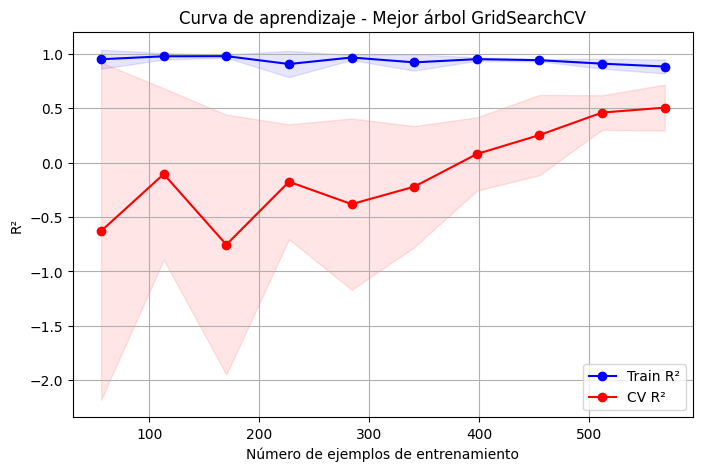

Profundidad del mejor árbol: 7
Train R² (con todos los datos): 0.821445228736036
CV R² promedio: -0.0961811545675354


In [ ]:
# Mejor árbol de GridSearchCV
best_tree_grid = grid.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_tree_grid,
    X_train, y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV R²')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor árbol GridSearchCV")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

# Resultados finales
print("Profundidad del mejor árbol:", best_tree_grid.get_depth())
print("Train R² (con todos los datos):", r2_score(y_train, best_tree_grid.predict(X_train)))
print("CV R² promedio:", np.mean(val_scores))


## RandomSearch

In [ ]:
param_dist = {
    "max_depth": [3, 5, 7, 10, 21, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1]
}

random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # probará 100 combinaciones aleatorias
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Mejores parámetros:", random_search.best_params_)

Mejores parámetros: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 7, 'ccp_alpha': 0.0}


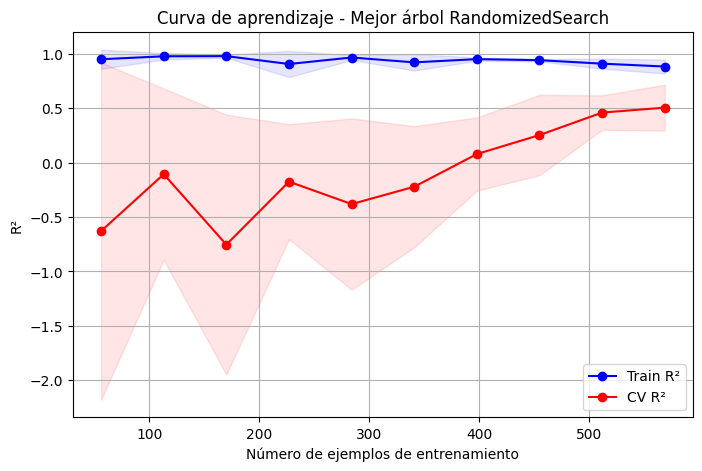

Profundidad del mejor árbol: 7
Train R² (con todos los datos): 0.8214928209111874
CV R² promedio: -0.09619090041347485


In [ ]:
# Mejor árbol de RandomizedSearchCV
best_tree = random_search.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    X_train, y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV R²')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor árbol RandomizedSearch")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

# Mostrar resultados finales
print("Profundidad del mejor árbol:", best_tree.get_depth())
print("Train R² (con todos los datos):", r2_score(y_train, best_tree.predict(X_train)))
print("CV R² promedio:", np.mean(val_scores))


## Halving

In [ ]:
param_grid = {
    "max_depth": [3, 5, 7, 10, 21, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
    "ccp_alpha": [0.0, 0.01, 0.05, 0.1]
}

halving_search = HalvingGridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="r2",
    factor=2,  # descarta la mitad en cada ronda
    verbose=1
)

halving_search.fit(X_train, y_train)

print("Mejores parámetros:", halving_search.best_params_)

n_iterations: 7
n_required_iterations: 11
n_possible_iterations: 7
min_resources_: 10
max_resources_: 712
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1152
n_resources: 10
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits


Se truncaron las últimas líneas 5000 del resultado de transmisión.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning: R^2 score is not

----------
iter: 1
n_candidates: 576
n_resources: 20
Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [          nan           nan           nan ... -287.48648273 -287.48648273
 -287.48648273]
  warnings.warn(


----------
iter: 2
n_candidates: 288
n_resources: 40
Fitting 5 folds for each of 288 candidates, totalling 1440 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.71024413 -1.68822107
 -1.68822107]
  warnings.warn(


----------
iter: 3
n_candidates: 144
n_resources: 80
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -0.52174366 -0.52553958
 -0.52553958]
  warnings.warn(


----------
iter: 4
n_candidates: 72
n_resources: 160
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan ... -1.50079109 -1.5011552
 -1.5011552 ]
  warnings.warn(


----------
iter: 5
n_candidates: 36
n_resources: 320
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.38858193 0.3885797  0.3885797 ]
  warnings.warn(


----------
iter: 6
n_candidates: 18
n_resources: 640
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Mejores parámetros: {'ccp_alpha': 0.0, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 20}


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.38659311 0.38659311 0.38659311]
  warnings.warn(


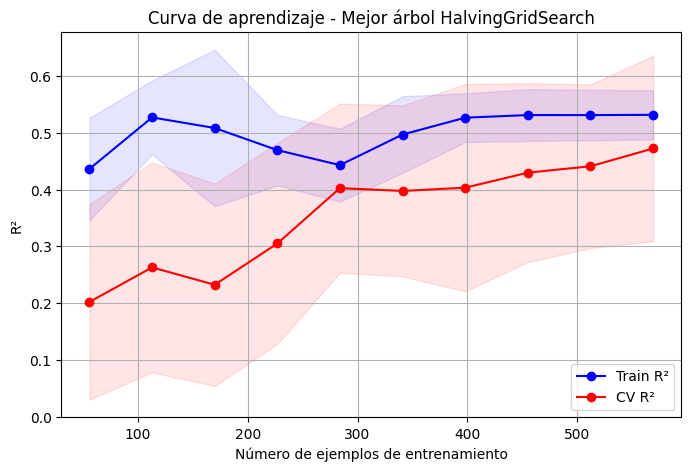

Profundidad del mejor árbol: 5
Train R² (con todos los datos): 0.513602066636655
CV R² promedio: 0.3549179181547054


In [ ]:
best_tree_halving = halving_search.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_tree_halving,
    X_train, y_train,
    cv=5,
    scoring='r2',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train R²')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV R²')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor árbol HalvingGridSearch")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.show()

# Resultados finales
print("Profundidad del mejor árbol:", best_tree_halving.get_depth())
print("Train R² (con todos los datos):", r2_score(y_train, best_tree_halving.predict(X_train)))
print("CV R² promedio:", np.mean(val_scores))

# Clasificacion

In [ ]:
target = 'survived'
data = df_class.copy()

num_features = [c for c in ['age','sibsp','parch','familysize'] if c in data.columns]
cat_features = [c for c in ['sex','embarked','embark_town','pclass','class','who','adult_male','alone','age_group','pclass_sex'] if c in data.columns]

X = data.drop(columns=[target])
y = data[target]

# --- Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Pipelines para columnas ---
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, num_features),
    ("cat", categorical_pipeline, cat_features)
])

In [ ]:
pipe_log = Pipeline([
    ("prep", preprocessor),
    ("clf", LogisticRegression(max_iter=5000, random_state=42))
])

# Entrenar modelo
pipe_log.fit(X_train, y_train)

# Predicciones
y_pred = pipe_log.predict(X_test)

# Métricas principales
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matriz de confusión
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Reporte completo por clase
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8324022346368715
Confusion matrix:
 [[101   9]
 [ 21  48]]

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87       110
           1       0.84      0.70      0.76        69

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



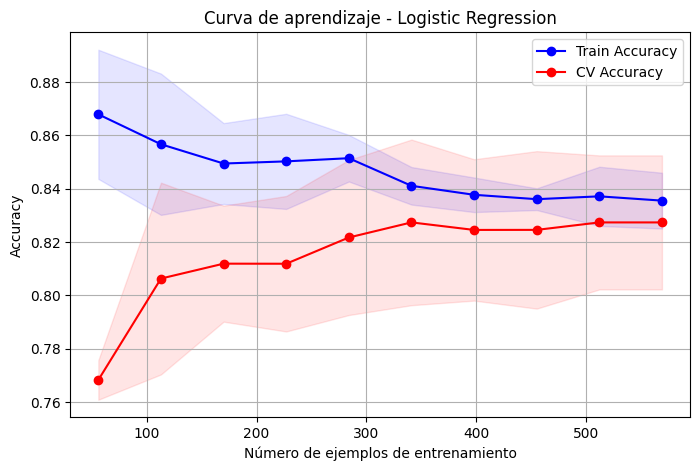

In [ ]:
# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    pipe_log,           # tu pipeline con preprocesamiento + modelo
    X_train,
    y_train,
    cv=5,
    scoring=make_scorer(accuracy_score),  # métricas de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Logistic Regression")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

### GridSearch

In [ ]:
param_grid = {
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__solver": ["liblinear", "saga"],  # soportan l1 y elasticnet
    "clf__l1_ratio": [0, 0.5, 1]           # solo aplica si penalty="elasticnet"
}
grid_search = GridSearchCV(
    pipe_log,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)


grid_search.fit(X_train, y_train)


print("Mejores parámetros (GridSearch):", grid_search.best_params_)
print("Mejor score CV (GridSearch):", grid_search.best_score_)
print("Score en test (GridSearch):", grid_search.score(X_test, y_test))

Mejores parámetros (GridSearch): {'clf__C': 1, 'clf__l1_ratio': 0, 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor score CV (GridSearch): 0.8315473259135231
Score en test (GridSearch): 0.8212290502793296


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **

In [ ]:
''' param_grid = [
    {
        "clf__penalty": ["l1", "l2"],
        "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "clf__solver": ["liblinear"]
    },
    {
        "clf__penalty": ["elasticnet"],
        "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
        "clf__solver": ["saga"],
        "clf__l1_ratio": [0, 0.5, 1]
    }
]  '''

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179



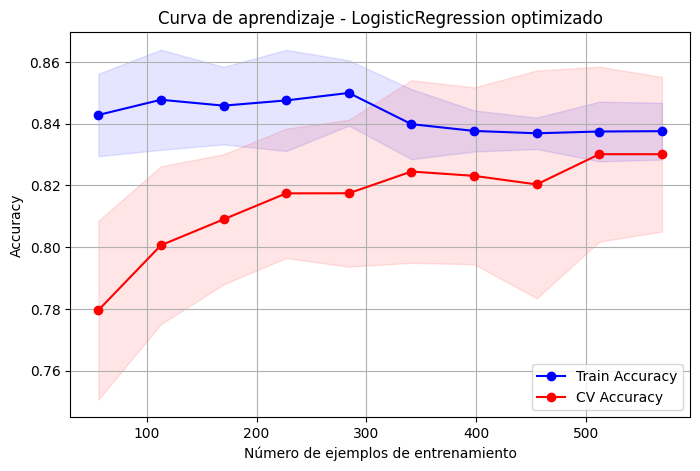

Train accuracy (todos los datos): 0.8342696629213483
CV accuracy promedio: 0.8152457401753175


In [ ]:
best_log = grid_search.best_estimator_
y_test_pred = best_log.predict(X_test)

print(classification_report(y_test, y_test_pred))
# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_log,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',  # métrica de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - LogisticRegression optimizado")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Resultados finales
print("Train accuracy (todos los datos):", accuracy_score(y_train, best_log.predict(X_train)))
print("CV accuracy promedio:", np.mean(val_scores))

In [ ]:
param_dist = {
    "clf__penalty": ["l1", "l2", "elasticnet"],
    "clf__C": loguniform(1e-3, 1e3),     # distribución continua
    "clf__solver": ["liblinear", "saga"],
    "clf__l1_ratio": np.linspace(0, 1, 5) # si elasticnet
}

random_search = RandomizedSearchCV(
    pipe_log,
    param_distributions=param_dist,
    n_iter=50,  # número de combinaciones a probar
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Mejores parámetros (RandomizedSearch):", random_search.best_params_)
print("Mejor score CV (RandomizedSearch):", random_search.best_score_)
print("Score en test (RandomizedSearch):", random_search.score(X_test, y_test))


Mejores parámetros (RandomizedSearch): {'clf__C': np.float64(0.3674904945305324), 'clf__l1_ratio': np.float64(0.25), 'clf__penalty': 'l1', 'clf__solver': 'liblinear'}
Mejor score CV (RandomizedSearch): 0.8329459273121245
Score en test (RandomizedSearch): 0.8268156424581006


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
25 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l

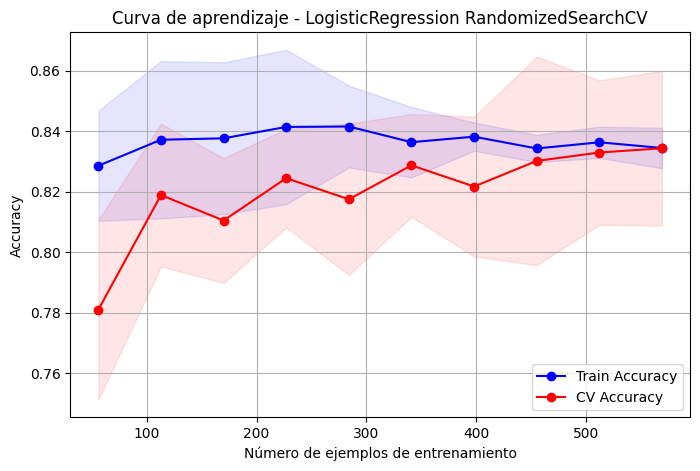

Score en test (accuracy): 0.8268156424581006
Classification report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87       110
           1       0.84      0.68      0.75        69

    accuracy                           0.83       179
   macro avg       0.83      0.80      0.81       179
weighted avg       0.83      0.83      0.82       179

Confusion matrix:
 [[101   9]
 [ 22  47]]


In [ ]:
# Mejor modelo de RandomizedSearchCV
best_log_rand = random_search.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_log_rand,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',  # métricas de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - LogisticRegression RandomizedSearchCV")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Métricas en test
y_test_pred = best_log_rand.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)

print("Score en test (accuracy):", accuracy_test)
print("Classification report:\n", classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

In [ ]:
param_grid_halving = {
    "clf__penalty": ["l1", "l2", "elasticnet", None],
    "clf__C": [0.001, 0.01, 0.1, 1, 10, 100],
    "clf__solver": ["liblinear", "saga"],  # soportan l1 y elasticnet
    "clf__l1_ratio": [0, 0.5, 1]
}

halving_search = HalvingGridSearchCV(
    pipe_log,
    param_grid=param_grid_halving,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    factor=2,  # descarta la mitad en cada ronda
    verbose=1
)

halving_search.fit(X_train, y_train)

print("Mejores parámetros (Halving):", halving_search.best_params_)
print("Mejor score CV (Halving):", halving_search.best_score_)
print("Score en test (Halving):", halving_search.score(X_test, y_test))

n_iterations: 6
n_required_iterations: 8
n_possible_iterations: 6
min_resources_: 20
max_resources_: 712
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 144
n_resources: 20
Fitting 5 folds for each of 144 candidates, totalling 720 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **

----------
iter: 1
n_candidates: 72
n_resources: 40
Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.4        0.6        0.6               nan 0.6
        nan 0.76666667 0.5        0.4        0.6        0.6
        nan 0.4               nan 0.76666667 0.5        0.4
 0.6        0.6               nan 0.4               nan 0.76666667
 0.66666667 0.55       0.65       0.7               nan 0.7
        nan 0.76666667 0.66666667 0.55       0.65       0.

----------
iter: 2
n_candidates: 36
n_resources: 80
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.4        0.6        0.6               nan 0.6
        nan 0.76666667 0.5        0.4        0.6        0.6
        nan 0.4               nan 0.76666667 0.5        0.4
 0.6        0.6               nan 0.4               nan 0.76666667
 0.66666667 0.55       0.65       0.7               nan 0.7
        nan 0.76666667 0.66666667 0.55       0.65       0.

----------
iter: 3
n_candidates: 18
n_resources: 160
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.4        0.6        0.6               nan 0.6
        nan 0.76666667 0.5        0.4        0.6        0.6
        nan 0.4               nan 0.76666667 0.5        0.4
 0.6        0.6               nan 0.4               nan 0.76666667
 0.66666667 0.55       0.65       0.7               nan 0.7
        nan 0.76666667 0.66666667 0.55       0.65       0.

----------
iter: 4
n_candidates: 9
n_resources: 320
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.4        0.6        0.6               nan 0.6
        nan 0.76666667 0.5        0.4        0.6        0.6
        nan 0.4               nan 0.76666667 0.5        0.4
 0.6        0.6               nan 0.4               nan 0.76666667
 0.66666667 0.55       0.65       0.7               nan 0.7
        nan 0.76666667 0.66666667 0.55       0.65       0.

----------
iter: 5
n_candidates: 5
n_resources: 640
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Mejores parámetros (Halving): {'clf__C': 10, 'clf__l1_ratio': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Mejor score CV (Halving): 0.8274114173228346
Score en test (Halving): 0.8212290502793296


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.6        0.46666667 0.4               nan 0.4
        nan 0.76666667 0.5        0.6        0.46666667 0.4
        nan 0.6               nan 0.76666667 0.5        0.6
 0.46666667 0.4               nan 0.6               nan 0.76666667
 0.5        0.4        0.6        0.6               nan 0.6
        nan 0.76666667 0.5        0.4        0.6        0.6
        nan 0.4               nan 0.76666667 0.5        0.4
 0.6        0.6               nan 0.4               nan 0.76666667
 0.66666667 0.55       0.65       0.7               nan 0.7
        nan 0.76666667 0.66666667 0.55       0.65       0.

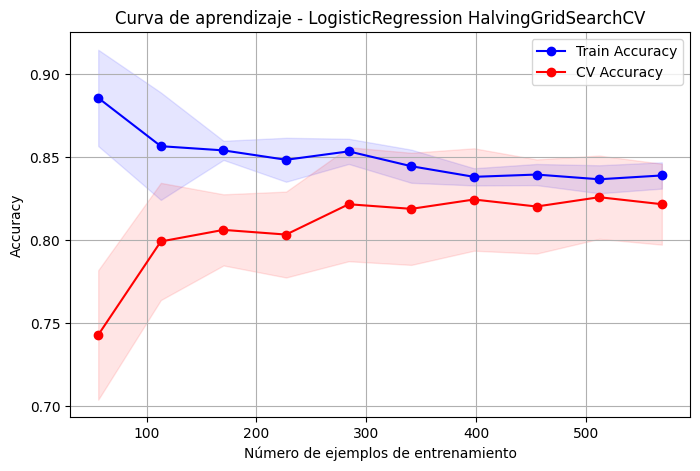

Score en test (accuracy): 0.8212290502793296
Classification report:
               precision    recall  f1-score   support

           0       0.81      0.92      0.86       110
           1       0.84      0.67      0.74        69

    accuracy                           0.82       179
   macro avg       0.83      0.79      0.80       179
weighted avg       0.82      0.82      0.82       179

Confusion matrix:
 [[101   9]
 [ 23  46]]


In [ ]:
# Mejor modelo de HalvingGridSearchCV
best_log_halving = halving_search.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_log_halving,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - LogisticRegression HalvingGridSearchCV")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Métricas en test
y_test_pred = best_log_halving.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)


print("Score en test (accuracy):", accuracy_test)
print("Classification report:\n", classification_report(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))

## Arboles de decision

In [ ]:
# Pipeline simple con preprocesador y DecisionTree
pipe_tree = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Entrenar modelo
pipe_tree.fit(X_train, y_train)

# Predicciones
y_pred = pipe_tree.predict(X_test)

# Métricas principales
print("Accuracy:", accuracy_score(y_test, y_pred))
# Matriz de confusión
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))

# Reporte completo por clase
print("\nClassification report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7877094972067039
Confusion matrix:
 [[96 14]
 [24 45]]

Classification report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83       110
           1       0.76      0.65      0.70        69

    accuracy                           0.79       179
   macro avg       0.78      0.76      0.77       179
weighted avg       0.79      0.79      0.78       179



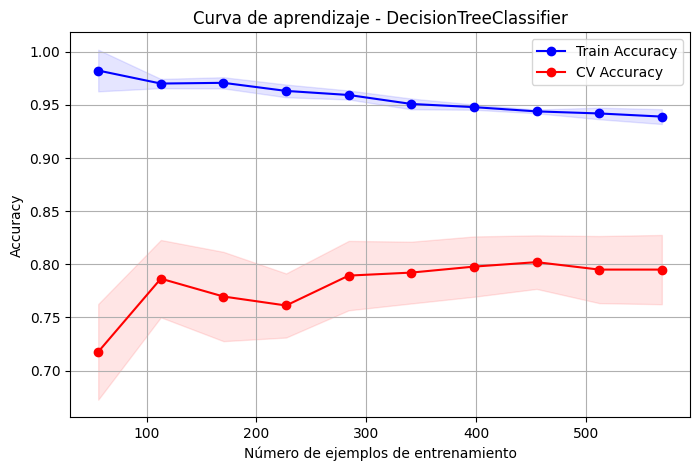

In [ ]:
# Mejor modelo base
tree_model = pipe_tree

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    tree_model,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',           # métrica de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - DecisionTreeClassifier")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
param_grid_tree = {
    "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 3, 5, 7, 10, 15, 20],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"]
}

grid_tree = GridSearchCV(
    pipe_tree,
    param_grid=param_grid_tree,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_tree.fit(X_train, y_train)

print("Mejores parámetros (GridSearch - Tree):", grid_tree.best_params_)
print("Mejor score CV (GridSearch - Tree):", grid_tree.best_score_)
print("Score en test (GridSearch - Tree):", grid_tree.score(X_test, y_test))


Mejores parámetros (GridSearch - Tree): {'clf__criterion': 'gini', 'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 5, 'clf__min_samples_split': 20}
Mejor score CV (GridSearch - Tree): 0.8315276273022751
Score en test (GridSearch - Tree): 0.8156424581005587


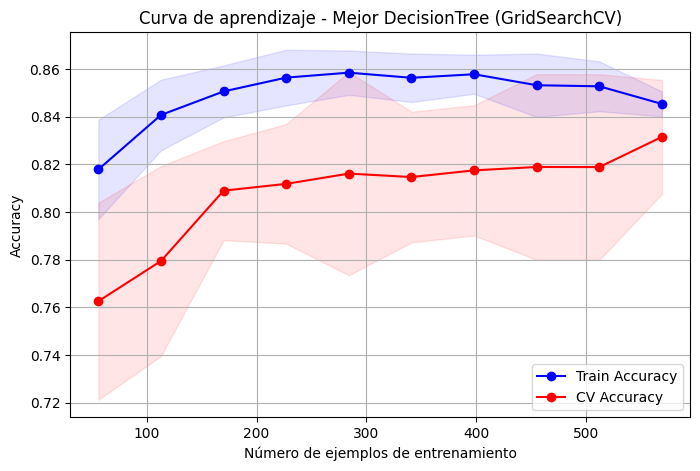

Accuracy en test: 0.8156424581005587
Confusion matrix:
 [[98 12]
 [21 48]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.86       110
           1       0.80      0.70      0.74        69

    accuracy                           0.82       179
   macro avg       0.81      0.79      0.80       179
weighted avg       0.81      0.82      0.81       179



In [ ]:
# Mejor árbol de GridSearchCV
best_tree = grid_tree.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor DecisionTree (GridSearchCV)")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Métricas finales en test
y_test_pred = best_tree.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print("Accuracy en test:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

In [ ]:
param_dist_tree = {
     "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 3, 5, 7, 10, 15, 20],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"]

}

random_tree = RandomizedSearchCV(
    pipe_tree,
    param_distributions=param_dist_tree,
    n_iter=50,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    random_state=42
)

random_tree.fit(X_train, y_train)

print("Mejores parámetros (RandomizedSearch - Tree):", random_tree.best_params_)
print("Mejor score CV (RandomizedSearch - Tree):", random_tree.best_score_)
print("Score en test (RandomizedSearch - Tree):", random_tree.score(X_test, y_test))

Mejores parámetros (RandomizedSearch - Tree): {'clf__min_samples_split': 5, 'clf__min_samples_leaf': 5, 'clf__max_features': 'sqrt', 'clf__max_depth': 7, 'clf__criterion': 'log_loss'}
Mejor score CV (RandomizedSearch - Tree): 0.8315177779966513
Score en test (RandomizedSearch - Tree): 0.7821229050279329


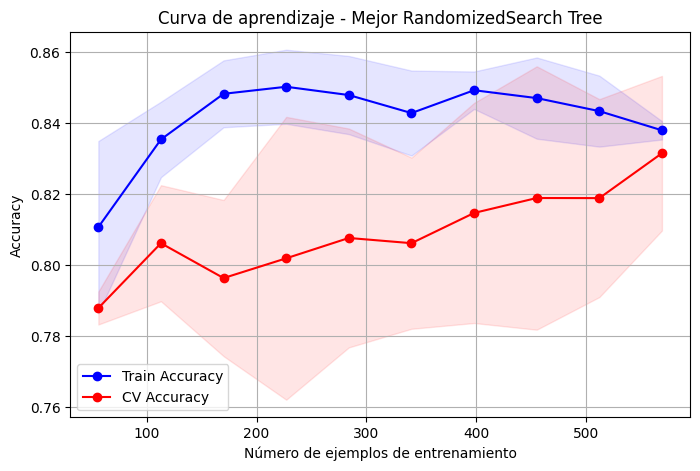

Accuracy en test: 0.7821229050279329
Confusion matrix:
 [[99 11]
 [28 41]]

Classification report:
               precision    recall  f1-score   support

           0       0.78      0.90      0.84       110
           1       0.79      0.59      0.68        69

    accuracy                           0.78       179
   macro avg       0.78      0.75      0.76       179
weighted avg       0.78      0.78      0.77       179



In [ ]:
# Mejor árbol de RandomizedSearchCV
best_random_tree = random_tree.best_estimator_

# Curva de aprendizaje
train_sizes, train_scores, val_scores = learning_curve(
    best_random_tree,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',          # métrica de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor RandomizedSearch Tree")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Métricas finales en test
y_test_pred = best_random_tree.predict(X_test)
print("Accuracy en test:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

In [ ]:
param_grid_halving_tree = {
     "clf__criterion": ["gini", "entropy", "log_loss"],
    "clf__max_depth": [None, 3, 5, 7, 10, 15, 20],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": [None, "sqrt", "log2"]
}

halving_tree = HalvingGridSearchCV(
    pipe_tree,
    param_grid=param_grid_halving_tree,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    factor=2,
    verbose=1
)

halving_tree.fit(X_train, y_train)

print("Mejores parámetros (Halving - Tree):", halving_tree.best_params_)
print("Mejor score CV (Halving - Tree):", halving_tree.best_score_)
print("Score en test (Halving - Tree):", halving_tree.score(X_test, y_test))

n_iterations: 6
n_required_iterations: 10
n_possible_iterations: 6
min_resources_: 20
max_resources_: 712
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 1008
n_resources: 20
Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
----------
iter: 1
n_candidates: 504
n_resources: 40
Fitting 5 folds for each of 504 candidates, totalling 2520 fits
----------
iter: 2
n_candidates: 252
n_resources: 80
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
----------
iter: 3
n_candidates: 126
n_resources: 160
Fitting 5 folds for each of 126 candidates, totalling 630 fits
----------
iter: 4
n_candidates: 63
n_resources: 320
Fitting 5 folds for each of 63 candidates, totalling 315 fits
----------
iter: 5
n_candidates: 32
n_resources: 640
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Mejores parámetros (Halving - Tree): {'clf__criterion': 'log_loss', 'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10, 'clf

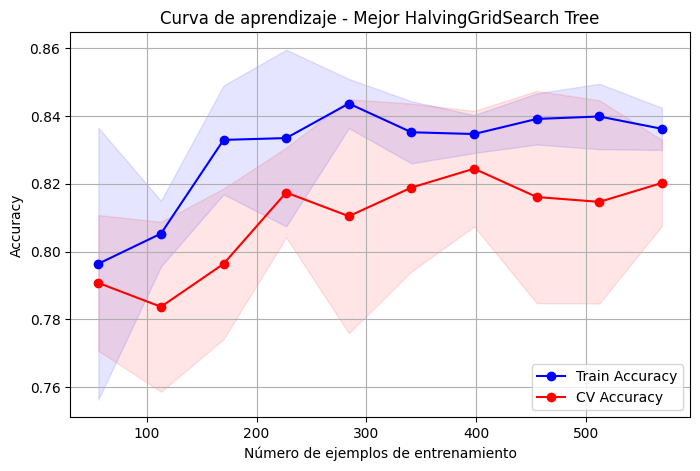

Accuracy en test: 0.7988826815642458
Confusion matrix:
 [[97 13]
 [23 46]]

Classification report:
               precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [ ]:
# Mejor árbol del HalvingGridSearchCV
best_halving_tree = halving_tree.best_estimator_

# Curva de aprendizaje con el mejor árbol del HalvingGridSearchCV
train_sizes, train_scores, val_scores = learning_curve(
    best_halving_tree,
    X_train,
    y_train,
    cv=5,
    scoring='accuracy',          # métrica de clasificación
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42,
    n_jobs=-1
)

# Promedio y desviación estándar
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Graficar curvas de aprendizaje
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean, 'o-', color='red', label='CV Accuracy')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

plt.title("Curva de aprendizaje - Mejor HalvingGridSearch Tree")
plt.xlabel("Número de ejemplos de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Métricas finales en test
y_test_pred = best_halving_tree.predict(X_test)
print("Accuracy en test:", accuracy_score(y_test, y_test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

In [ ]:
results_compare = pd.DataFrame({
    "Logistic Base": [pipe_log.score(X_test, y_test)],
    "Logistic Grid": [grid_search.score(X_test, y_test)],
    "Logistic Random": [random_search.score(X_test, y_test)],
    "Logistic Halving": [halving_search.score(X_test, y_test)],
    "Tree Base": [pipe_tree.score(X_test, y_test)],
    "Tree Grid": [grid_tree.score(X_test, y_test)],
    "Tree Random": [random_tree.score(X_test, y_test)],
    "Tree Halving": [halving_tree.score(X_test, y_test)]
}, index=["Accuracy Test"]).T

results_compare


,Accuracy Test
Logistic Base,0.832402
Logistic Grid,0.821229
Logistic Random,0.826816
Logistic Halving,0.821229
Tree Base,0.787709
Tree Grid,0.815642
Tree Random,0.782123
Tree Halving,0.798883
